# Skin Lesion Classifier - Hyperparameter Optimization

## Environment

### Check whether you’re running Pillow or Pillow-SIMD?

In [1]:
# According to the author, if PILLOW_VERSION has a postfix, it is Pillow-SIMD0.
# (Assuming that Pillow will never make a .postX release).
!python3 -c "from PIL import Image; print(Image.PILLOW_VERSION)"

5.4.1


### Whether Pillow or Pillow-SIMD is using libjpeg-turbo?

In [2]:
from PIL import features, Image
from packaging import version

if version.parse(Image.PILLOW_VERSION) >= version.parse("5.4.0"):
    if features.check_feature('libjpeg_turbo'):
        print("libjpeg-turbo is on")
    else:
        print("libjpeg-turbo is not on")
else:
    print("libjpeg-turbo' status can't be derived - need Pillow(-SIMD)? >= 5.4.0 to tell, current version {}".format(Image.PILLOW_VERSION))

libjpeg-turbo is not on


### Confirm TensorFlow can see the GPU

In [3]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


### System Information

In [ ]:
import tensorflow as tf
import platform
from tensorflow.python.client import device_lib
import tensorflow.keras

!python3 --version

print('\nTensorFlow Version: ', tf.__version__)

print('\nNVIDIA:')
!nvcc --version
!nvidia-smi
!nvidia-smi topo -m

print('\nCPU:')
!lscpu

print('\nMemory:')
!cat /proc/meminfo

print('\nOS:')
print(platform.platform())

print('\nDevices:')
print(device_lib.list_local_devices())

## Common Parameters

In [2]:
sys.path.append("..") # Adds higher directory to python modules path.
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import *
from visuals import *
from data.data import *
from collections import Counter

%load_ext autoreload
%autoreload 2
%matplotlib inline

data_folder = '../data/isic2019'

model_folder = 'models'
history_folder = 'history'
pred_result_folder_val = 'val_predict_results'
out_dist_pred_result_folder = 'out_dist_predict_results'
    
workers = os.cpu_count()

# How to handle SVG fonts
plt.rcParams['svg.fonttype'] = 'none'

## Import Training Data

Number of known categories: 8
['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'] 

Number of unknown categories: 1
UNK 

Category to Index:
{'MEL': 0, 'NV': 1, 'BCC': 2, 'AK': 3, 'BKL': 4, 'DF': 5, 'VASC': 6, 'SCC': 7, 'UNK': 8} 

Training data has 5996 samples.
'MEL':	1071	(17.86%)
'NV':	3049	(50.85%)
'BCC':	787	(13.13%)
'AK':	205	(3.42%)
'BKL':	621	(10.36%)
'DF':	56	(0.93%)
'VASC':	148	(2.47%)
'SCC':	59	(0.98%)
'UNK':	0	(0.00%)


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,path,category
0,ISIC_0055626,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/isic2019/ISIC_2019_Training_Input/ISIC...,1
1,ISIC_0032542,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/isic2019/ISIC_2019_Training_Input/ISIC...,1
2,ISIC_0031041,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/isic2019/ISIC_2019_Training_Input/ISIC...,2
3,ISIC_0063975,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/isic2019/ISIC_2019_Training_Input/ISIC...,1
4,ISIC_0060579,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,../data/isic2019/ISIC_2019_Training_Input/ISIC...,4


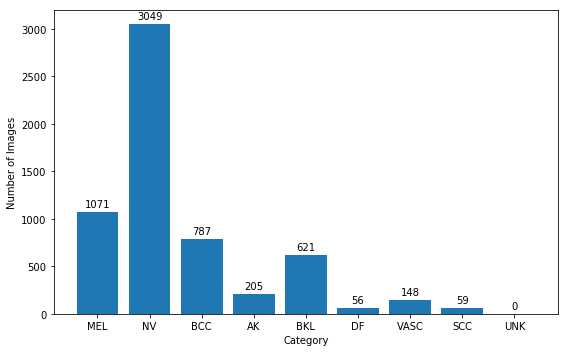

In [9]:
training_image_folder = os.path.join(data_folder, 'ISIC_2019_Training_Input')
ground_truth_file = os.path.join(data_folder, 'ISIC_2019_Training_GroundTruth.csv')

df_ground_truth, known_category_names, unknown_category_name = load_isic_training_data(training_image_folder, ground_truth_file)
known_category_num = len(known_category_names)
print("Number of known categories: {}".format(known_category_num))
print(known_category_names, '\n')
unknown_category_num = 1
print("Number of unknown categories: {}".format(unknown_category_num))
print(unknown_category_name, '\n')
all_category_names = known_category_names + [unknown_category_name]
all_category_num = known_category_num + unknown_category_num

# mapping from category to index
print('Category to Index:')
category_to_index = dict((c, i) for i, c in enumerate(all_category_names))
print(category_to_index, '\n')

count_per_category = Counter(df_ground_truth['category'])
total_sample_count = sum(count_per_category.values())
print("Training data has {} samples.".format(total_sample_count))
for i, c in enumerate(all_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category[i], count_per_category[i]*100/total_sample_count))

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('white')
ax.set(xlabel='Category', ylabel='Number of Images')
# plt.bar(count_per_category.keys(), count_per_category.values())
rects = plt.bar(all_category_names, [count_per_category[i] for i in range(all_category_num)])
autolabel(ax, rects)
fig.tight_layout()

df_ground_truth.head()

### Shuffle and Split Training Data into Training  and Validation Sets

In [10]:
df_train, df_val = train_validation_split(df_ground_truth)

# Training Set
sample_count_train = df_train.shape[0]
print("Training set has {} samples.".format(sample_count_train))
count_per_category_train = Counter(df_train['category'])
for i, c in enumerate(all_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category_train[i], count_per_category_train[i]*100/sample_count_train))

# Validation Set
sample_count_val = df_val.shape[0]
print("\nValidation set has {} samples.".format(sample_count_val))

Training set has 4796 samples.
'MEL':	857	(17.87%)
'NV':	2439	(50.85%)
'BCC':	629	(13.12%)
'AK':	164	(3.42%)
'BKL':	497	(10.36%)
'DF':	45	(0.94%)
'VASC':	118	(2.46%)
'SCC':	47	(0.98%)
'UNK':	0	(0.00%)

Validation set has 1200 samples.


### Class Weights based on the Traning Set

Class Weights (without UNK):
'MEL':	0.699533
'NV':	0.245797
'BCC':	0.953100
'AK':	3.655488
'BKL':	1.206237
'DF':	13.322222
'VASC':	5.080508
'SCC':	12.755319


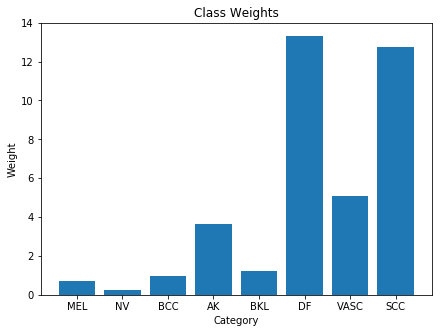

In [39]:
class_weight_dict, class_weights = compute_class_weight_dict(df_train)
print('Class Weights (without UNK):')
for i, c in enumerate(known_category_names):
    print("'%s':\t%f" % (c, class_weight_dict[i]))

# Create a bar chart
fig, ax = plt.subplots(figsize=(7, 5))
fig.patch.set_facecolor('white')
ax.set_title('Class Weights')
ax.set(xlabel='Category', ylabel='Weight')
plt.bar(known_category_names, [class_weight_dict[i] for i in range(known_category_num)]);

## DenseNet201 analysis

### Hyperparameter combinations (learning rate, dropout and batch size)

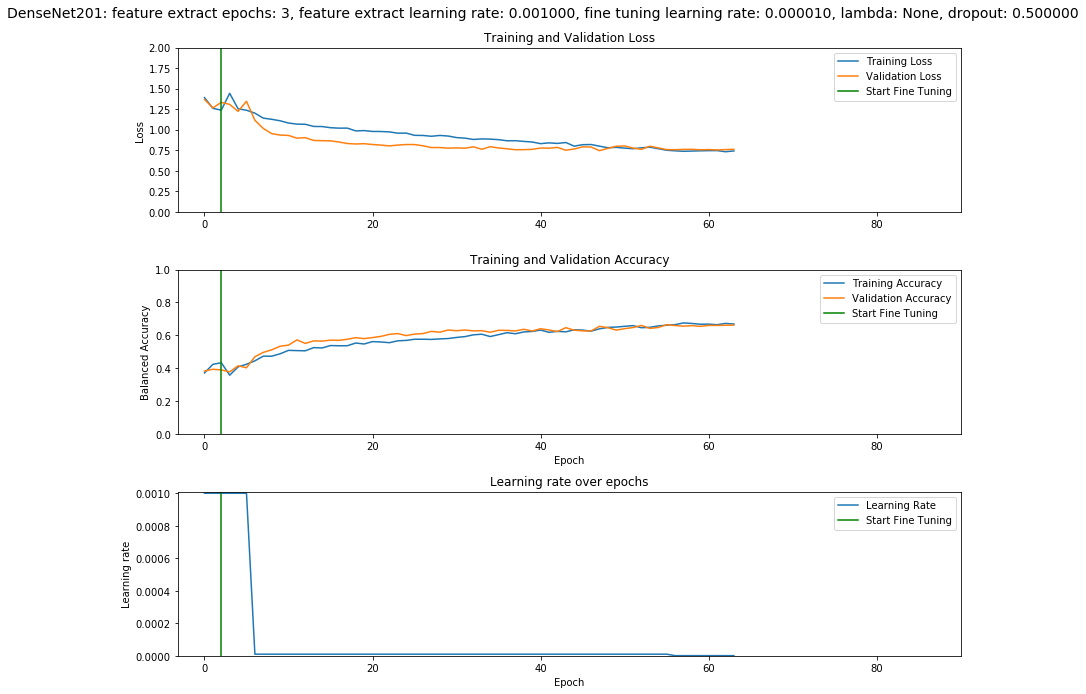

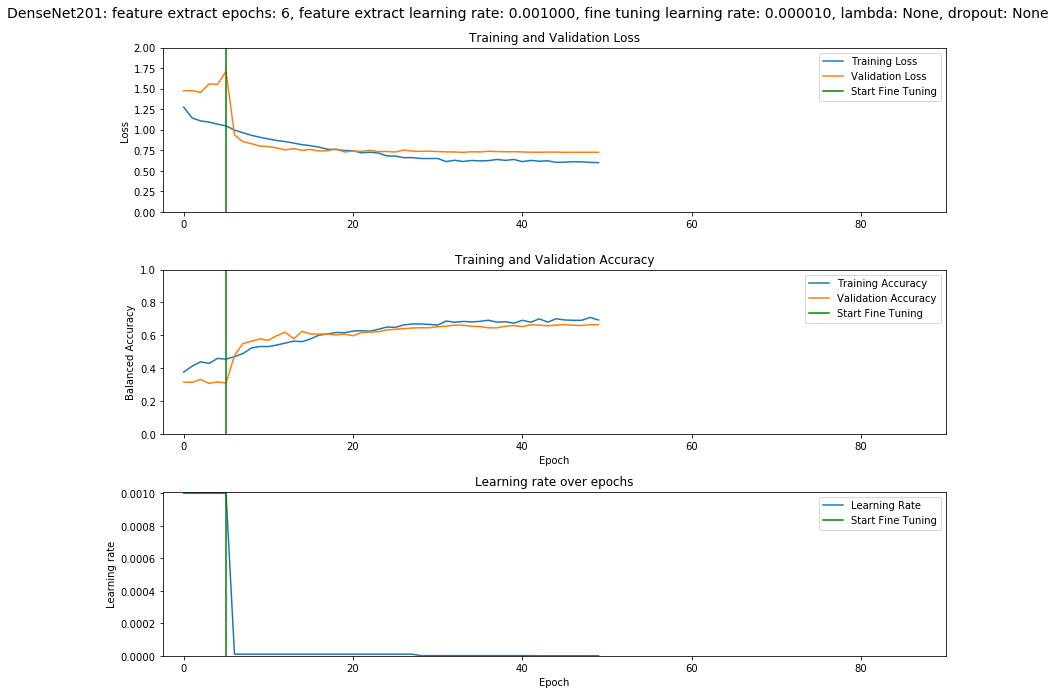

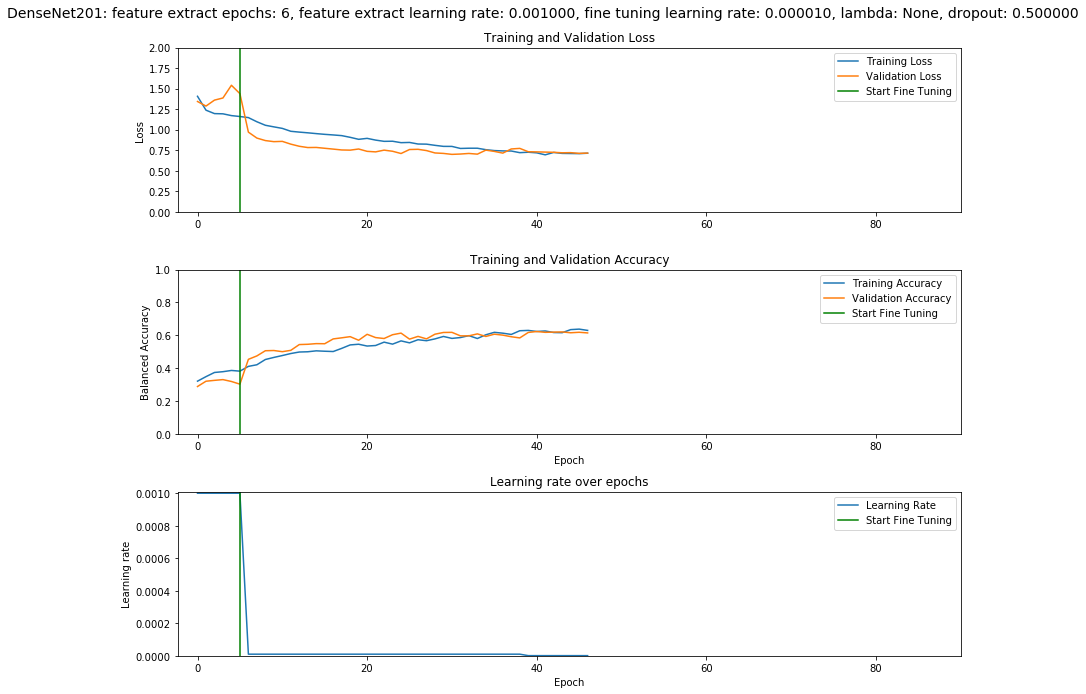

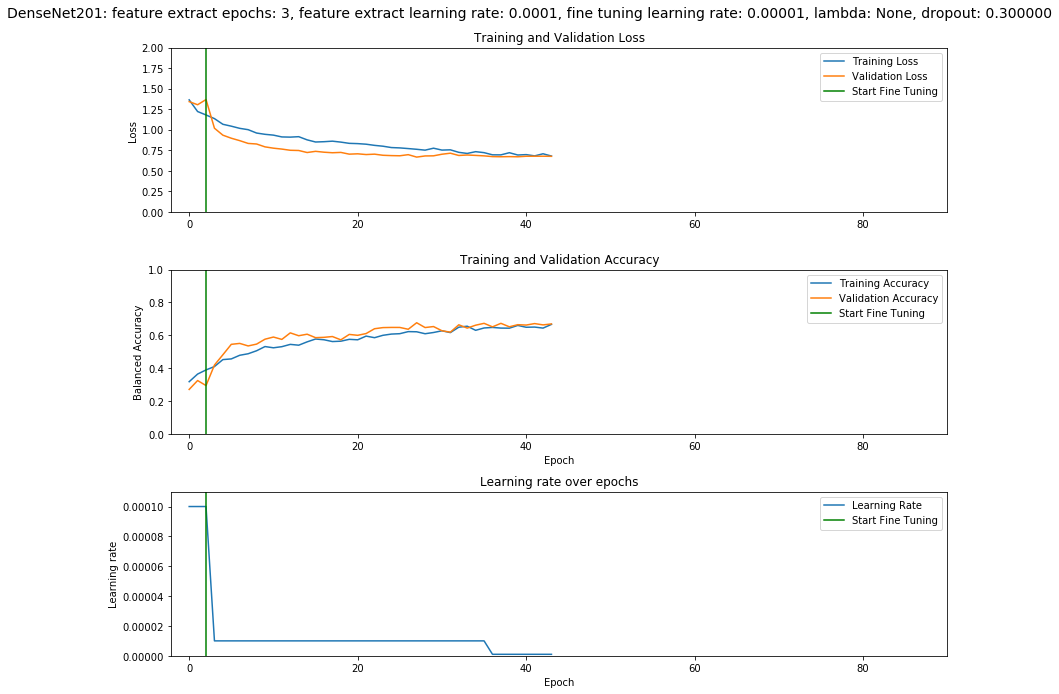

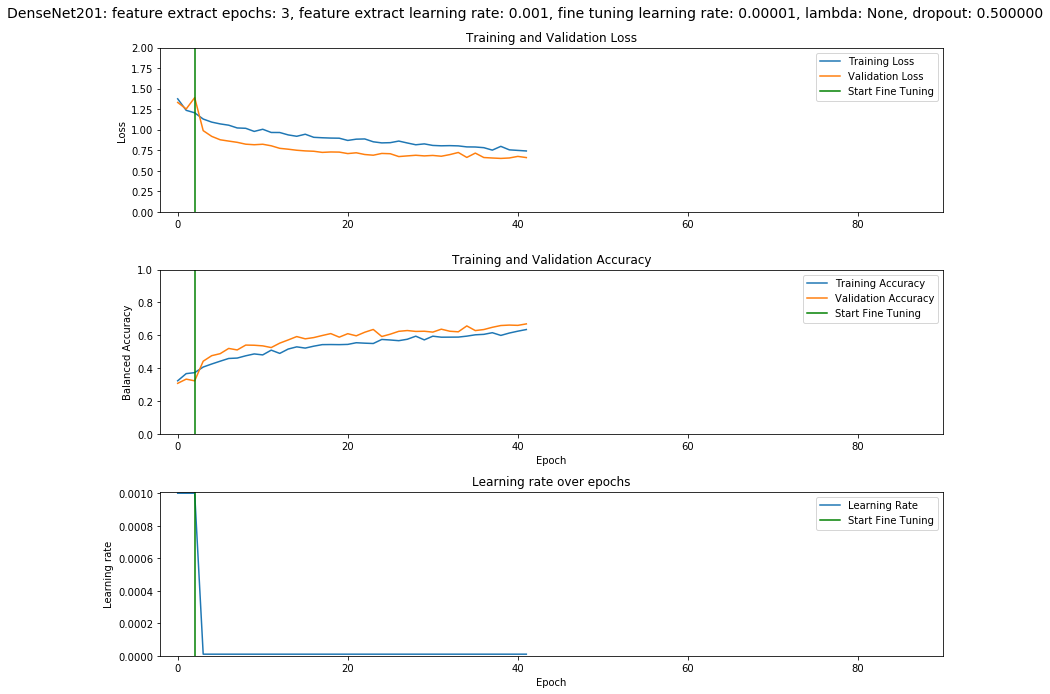

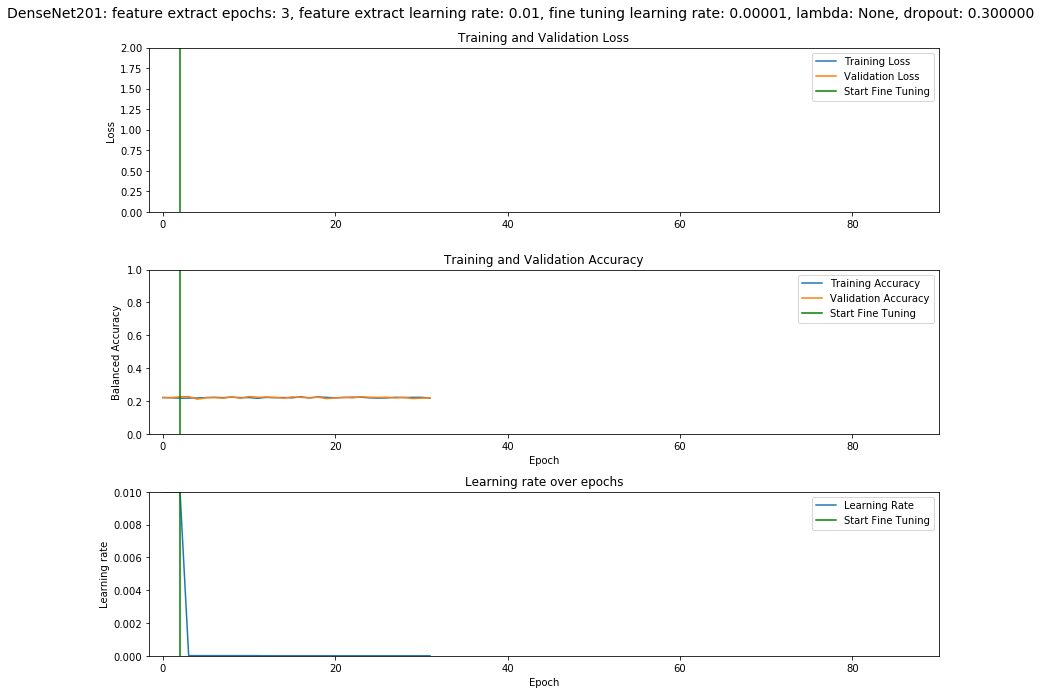

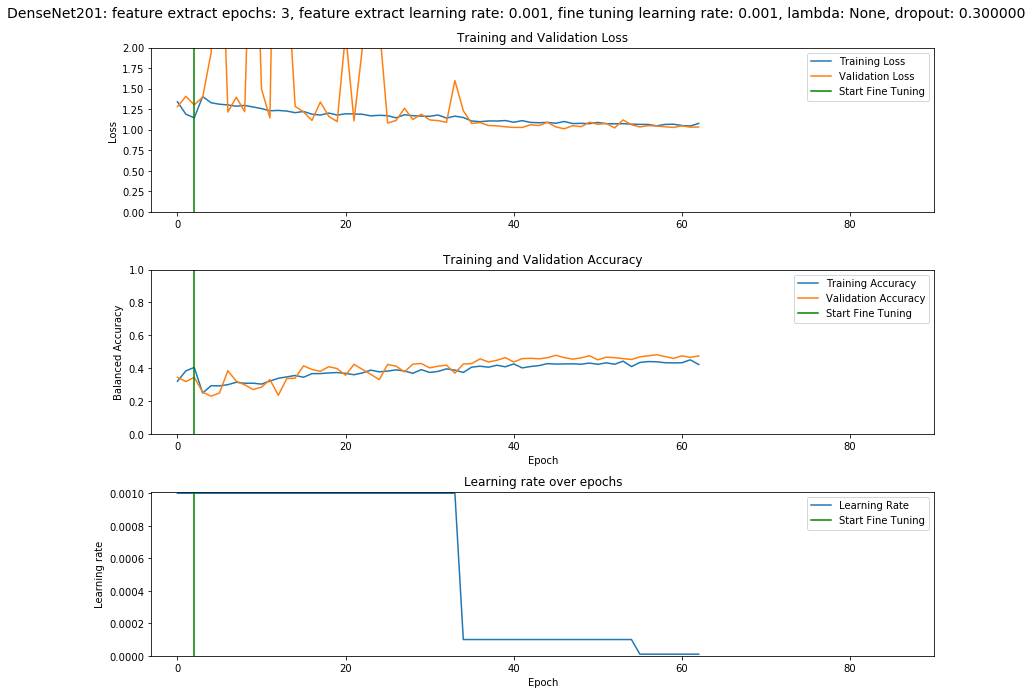

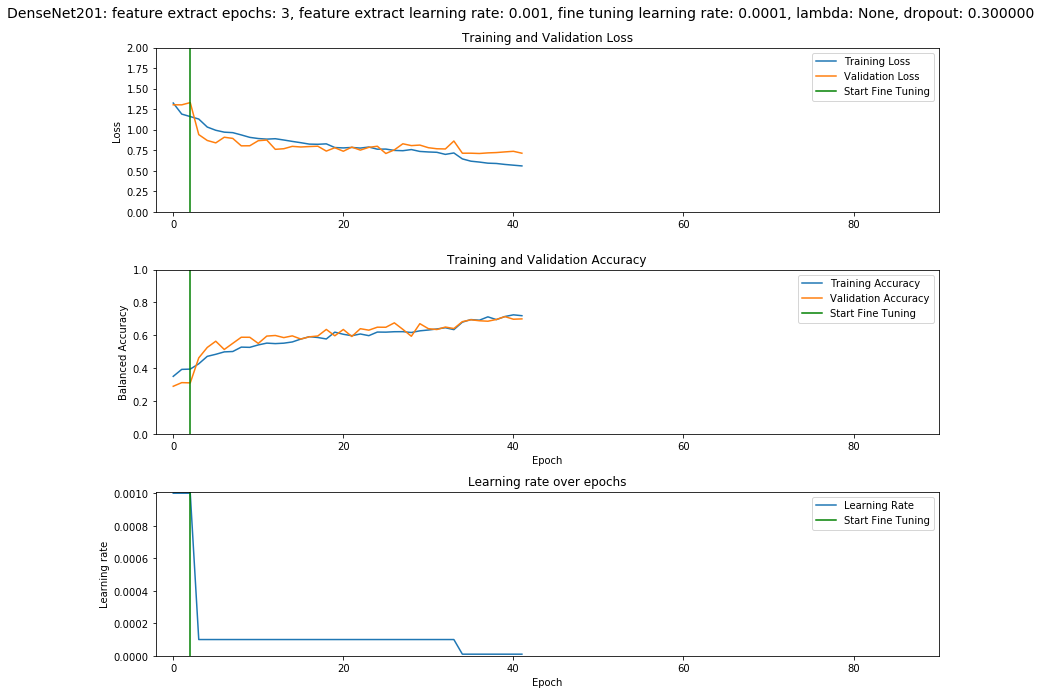

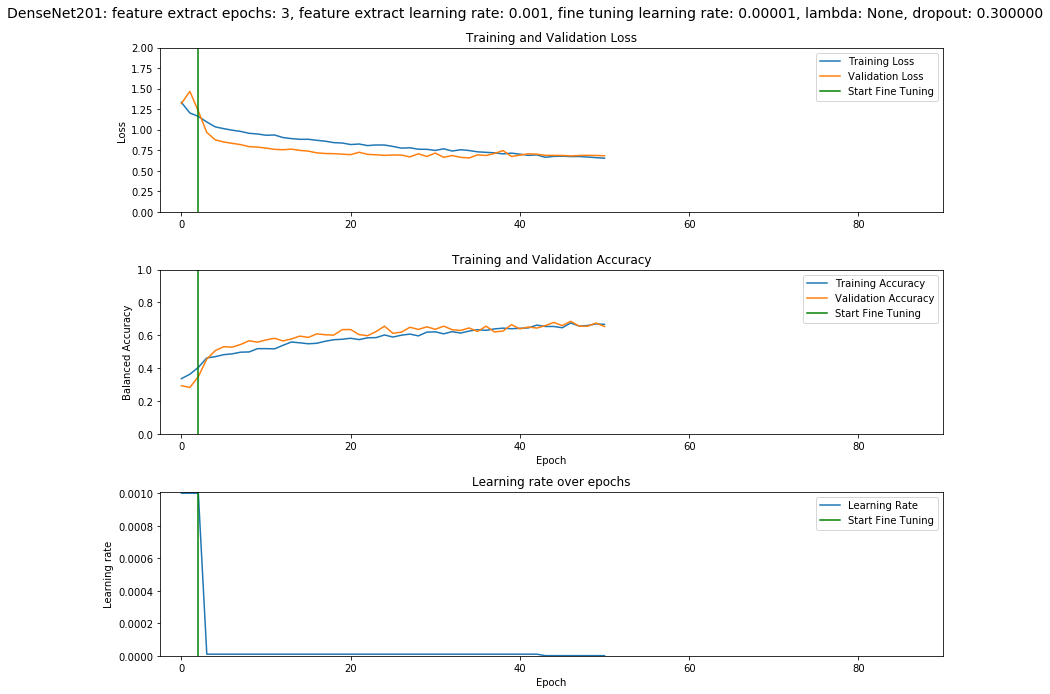

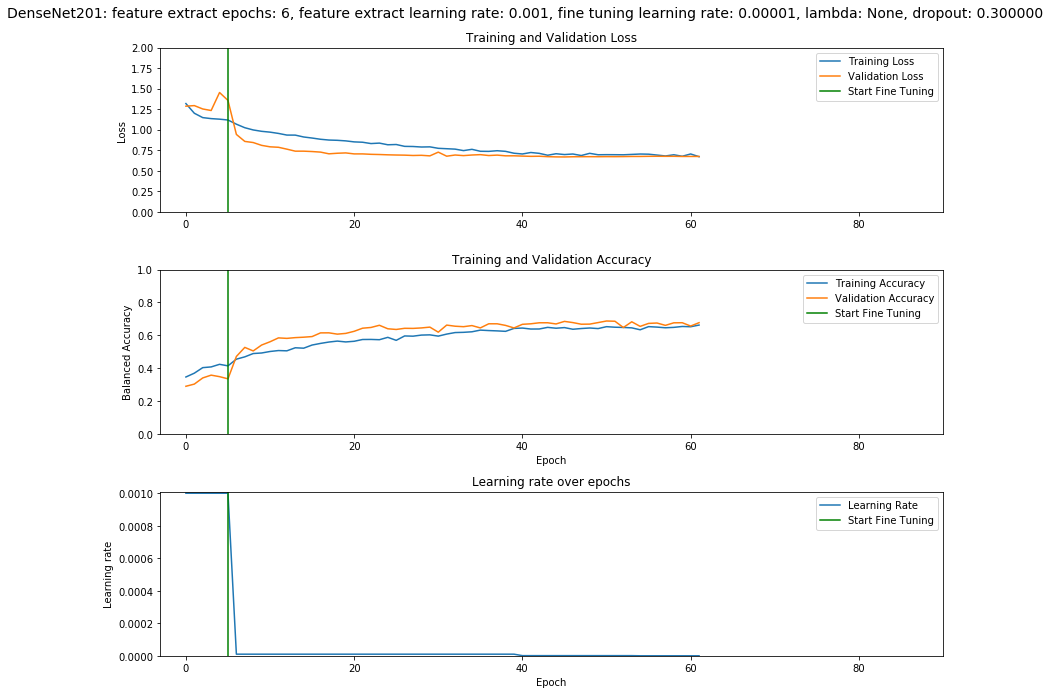

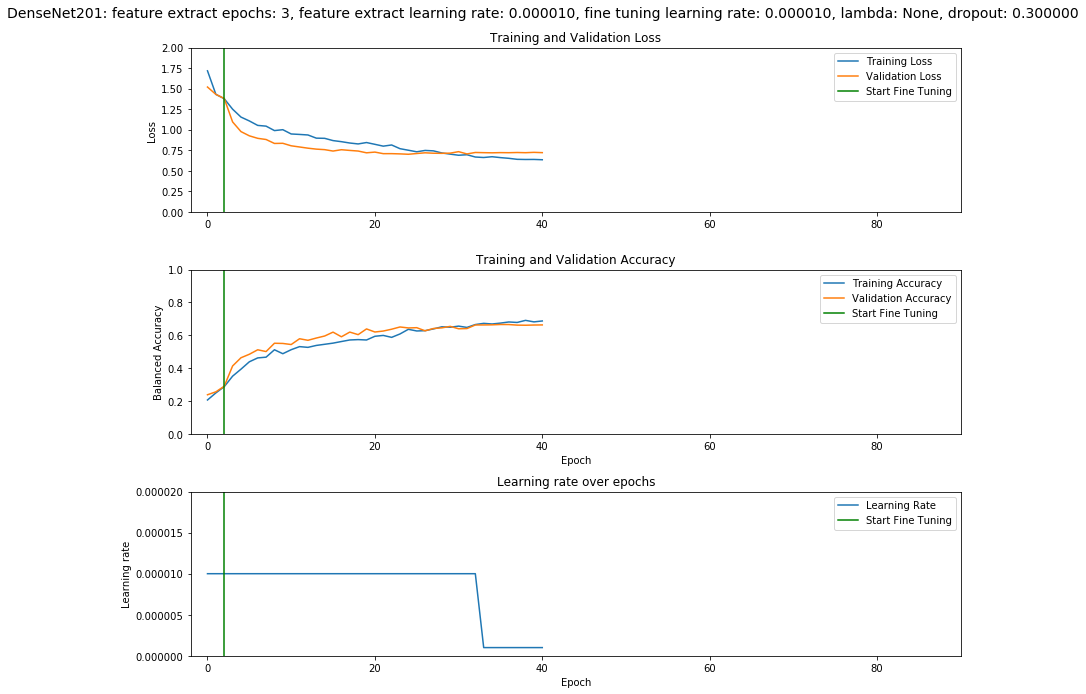

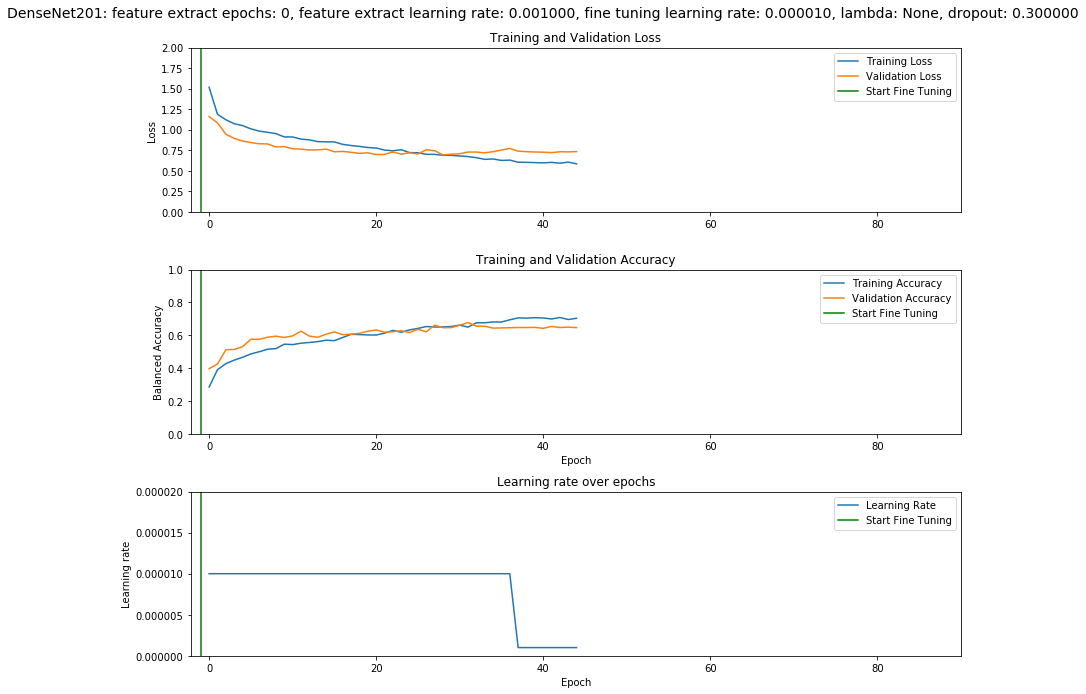

In [10]:
model_name = 'DenseNet201'
d=os.path.join("..", history_folder, model_name)
hyperparameter_combinations = [o for o in os.listdir(d) if os.path.isdir(os.path.join(d,o))]
feature_extract_epochs = 3
models_info = []

for i, combination in enumerate(hyperparameter_combinations):    
    file_path = os.path.join("..", history_folder, model_name, combination, "training.csv")
    hyperparameter_combination = combination.split("-")
    if(len(hyperparameter_combination)<=1):
        continue
    hyperparameters = {}
    model_info = {}
    for hyperparameter in hyperparameter_combination:
        split=hyperparameter.split("_")
        hyperparameters[split[0]] = split[1]
    model_info["hyperparameters"] = hyperparameters
    if os.path.exists(file_path):
        model_info["log"]=file_path
        fig = plot_complexity_graph(
            csv_file=file_path,
            title="{}: feature extract epochs: {}, feature extract learning rate: {}, fine tuning learning rate: {}, lambda: {}, dropout: {}".format(
                model_name, 
                hyperparameters["feepochs"],
                hyperparameters["felr"],
                hyperparameters["ftlr"],
                hyperparameters["lambda"],
                hyperparameters["dropout"]
            ),
            figsize=(12, 10),
            feature_extract_epochs=int(hyperparameters["feepochs"])
        )
        fig.savefig(
            os.path.join("..", history_folder, model_name, combination, "training.svg"), 
            format='svg',
            bbox_inches='tight', 
            pad_inches=0
        )
    models_info.append(model_info)

### Learning rate comparisson 

#### Feature extraction learning rate

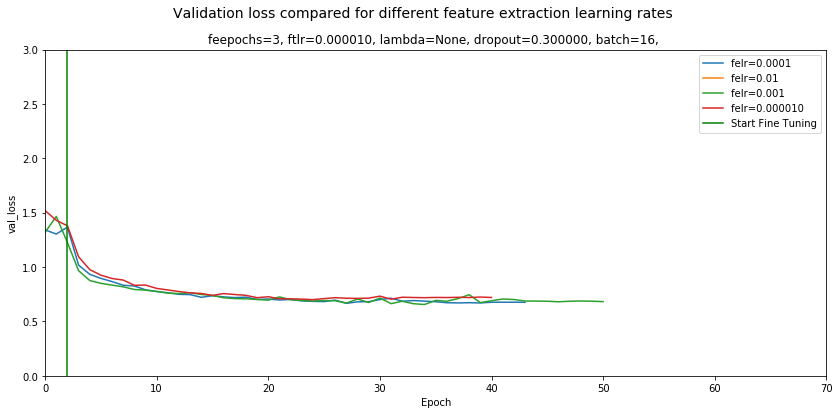

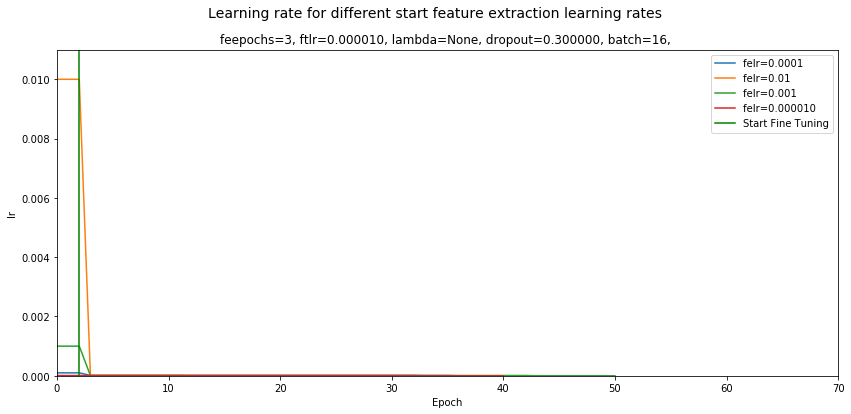

In [73]:
fig = plot_hyperparameter_comparisson_metric(
    models_info,
    "val_loss",
    0,
    3,
    hyperparameters_compared=["felr"],
    constant_parameters={
        "feepochs": 3, 
        "dropout": 0.3, 
        "ftlr": 0.00001, 
        "batch": 16,
        "lambda": None
    },
    title="Validation loss compared for different feature extraction learning rates",
    feature_extract_epochs=3,
    epoch_max=70
)

fig.savefig(
    os.path.join("..", history_folder, model_name, combination, "feature_extraction_learning_rate_loss.svg"), 
    format='svg',
    bbox_inches='tight', 
    pad_inches=0
)

fig2 = plot_hyperparameter_comparisson_metric(
    models_info,
    "lr",
    0,
    0.011,
    hyperparameters_compared=["felr"],
    constant_parameters={
        "feepochs": 3, 
        "dropout": 0.3, 
        "ftlr": 0.00001, 
        "batch": 16,
        "lambda": None
    },
    title="Learning rate for different start feature extraction learning rates",
    feature_extract_epochs=3,
    epoch_max=70
)

#### Fine tuning learning rate

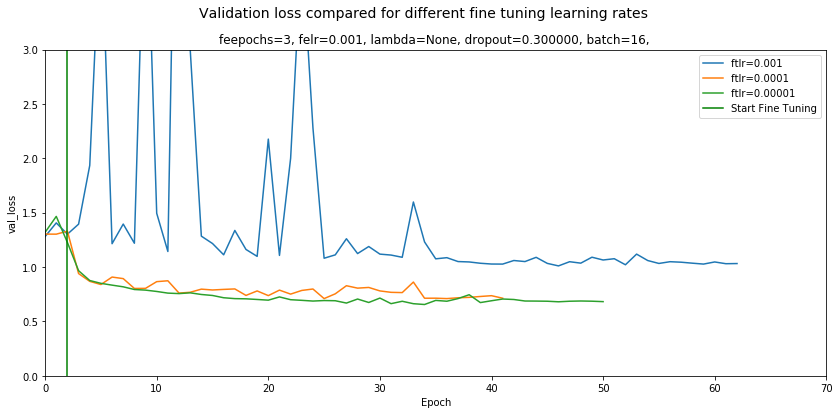

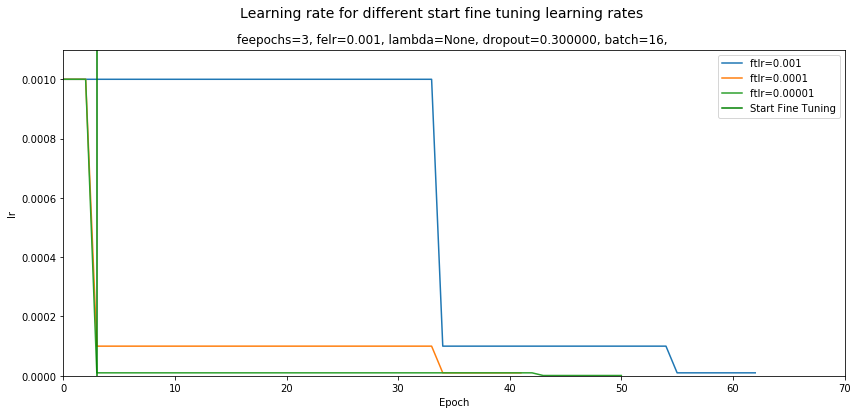

In [76]:
fig = plot_hyperparameter_comparisson_metric(
    models_info,
    "val_loss",
    0,
    3,
    hyperparameters_compared=["ftlr"],
    constant_parameters={
        "feepochs": 3, 
        "felr": 0.001, 
        "dropout": 0.3, 
        "batch": 16,
        "lambda": None
    },
    title="Validation loss compared for different fine tuning learning rates",
    feature_extract_epochs=3,
    epoch_max=70
)

fig.savefig(
    os.path.join("..", history_folder, model_name, combination, "fine_tuning_learning_rate_loss.svg"), 
    format='svg',
    bbox_inches='tight', 
    pad_inches=0
)

fig2 = plot_hyperparameter_comparisson_metric(
    models_info,
    "lr",
    0,
    0.0011,
    hyperparameters_compared=["ftlr"],
    constant_parameters={
        "feepochs": 3, 
        "felr": 0.001, 
        "dropout": 0.3, 
        "batch": 16,
        "lambda": None
    },
    title="Learning rate for different start fine tuning learning rates",
    feature_extract_epochs=4,
    epoch_max=70
)

### Dropout comparisson 

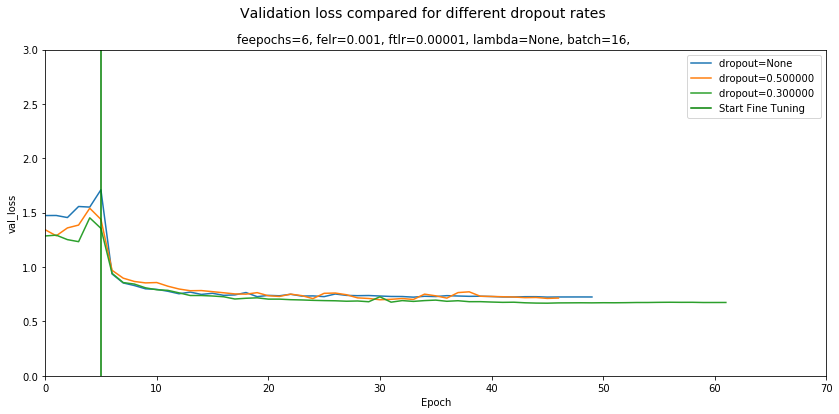

In [71]:
from visuals import *

fig = plot_hyperparameter_comparisson_metric(
    models_info,
    "val_loss",
    0,
    3,
    hyperparameters_compared=["dropout"],
    constant_parameters={
        "feepochs": 6, 
        "felr": 0.001, 
        "ftlr": 0.00001, 
        "batch": 16,
        "lambda": None
    },
    title="Validation loss compared for different dropout rates",
    feature_extract_epochs=6,
    epoch_max=70
)

fig.savefig(
    os.path.join("..", history_folder, model_name, combination, "dropout_loss.svg"), 
    format='svg',
    bbox_inches='tight', 
    pad_inches=0
)

### Feature extract epochs comparisson

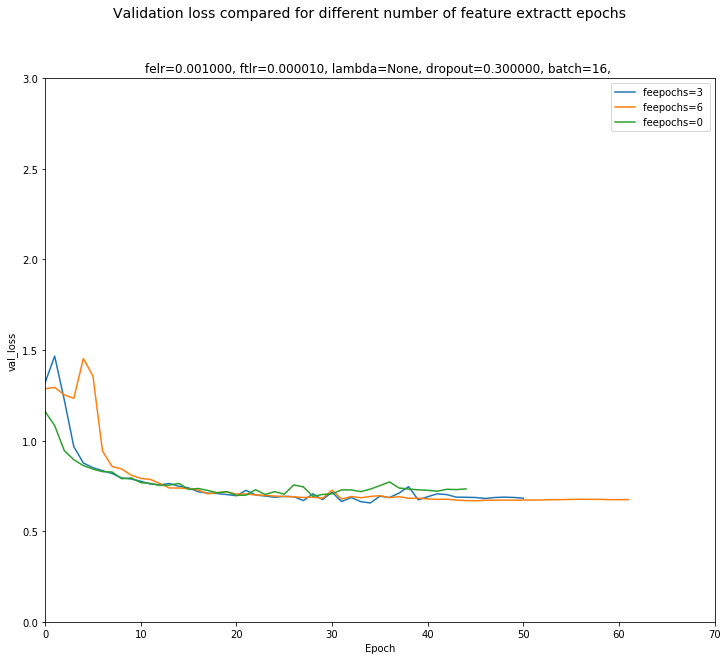

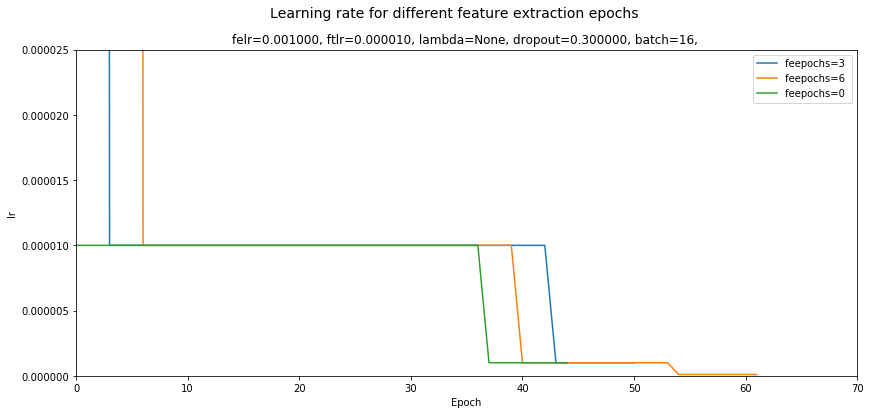

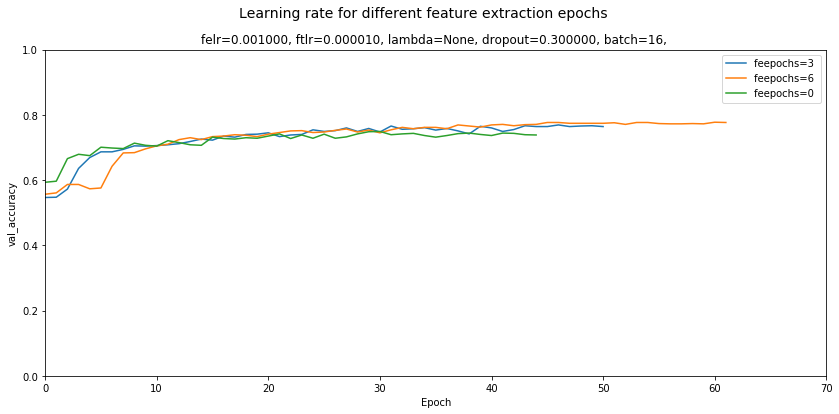

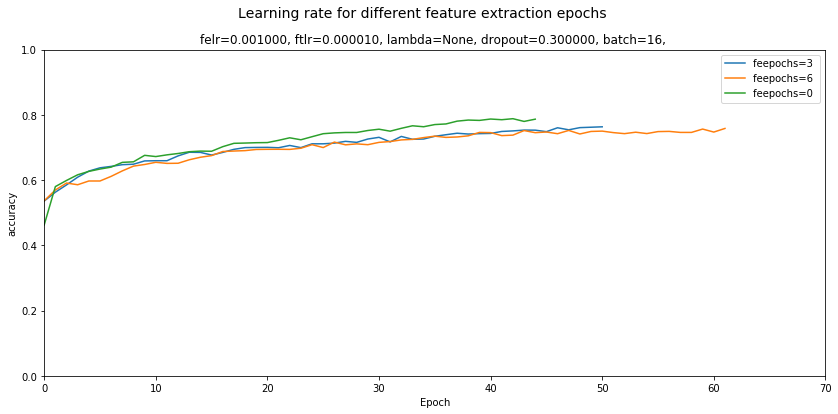

In [85]:
from visuals import *

fig = plot_hyperparameter_comparisson_metric(
    models_info,
    "val_loss",
    0,
    3,
    hyperparameters_compared=["feepochs"],
    constant_parameters={
        "dropout": 0.3, 
        "felr": 0.001, 
        "ftlr": 0.00001, 
        "batch": 16
    },
    title="Validation loss compared for different number of feature extractt epochs",
    figsize=(12, 10),
    feature_extract_epochs=None,
    epoch_max=70
)

fig.savefig(
    os.path.join("..", history_folder, model_name, combination, "dropout_loss.svg"), 
    format='svg',
    bbox_inches='tight', 
    pad_inches=0
)

fig2 = plot_hyperparameter_comparisson_metric(
    models_info,
    "lr",
    0,
    0.000025,
    hyperparameters_compared=["feepochs"],
    constant_parameters={
        "dropout": 0.3, 
        "felr": 0.001, 
        "ftlr": 0.00001, 
        "batch": 16
    },
    title="Learning rate for different feature extraction epochs",
    feature_extract_epochs=None,
    epoch_max=70
)

fig3 = plot_hyperparameter_comparisson_metric(
    models_info,
    "val_accuracy",
    0,
    1,
    hyperparameters_compared=["feepochs"],
    constant_parameters={
        "dropout": 0.3, 
        "felr": 0.001, 
        "ftlr": 0.00001, 
        "batch": 16
    },
    title="Learning rate for different feature extraction epochs",
    feature_extract_epochs=None,
    epoch_max=70
)


fig4 = plot_hyperparameter_comparisson_metric(
    models_info,
    "accuracy",
    0,
    1,
    hyperparameters_compared=["feepochs"],
    constant_parameters={
        "dropout": 0.3, 
        "felr": 0.001, 
        "ftlr": 0.00001, 
        "batch": 16
    },
    title="Learning rate for different feature extraction epochs",
    feature_extract_epochs=None,
    epoch_max=70
)